## Shortlist Promising Models - Random Forest Classifier

#### 0. Import modules and define parameters

In [1]:
import sys
sys.path.append("..")

from module.utils import general_utils
from module.utils import data_prepare_utils
import module.utils.bin_class_utils as bin_class_utils
from sklearn.pipeline import Pipeline
import time

In [2]:
start = time.time()

In [3]:
TRAIN_FILE_PATH = "../data/train_df.csv"
VALIDATION_FILE_PATH = "../data/validation_df.csv"

TARGET_ATTR = "label"
TARGET_TYPE = "binary"

ESTIMATOR_NAME = "RandomForestClassifier"

SAMPLE_SIZE = 0.05
SAMPLE_RANDOM_STATE = 24
TARGET_ENCODING_RANDOM_STATE = 42
MODEL_RANDOM_STATE = 42
PERMUTATION_IMPORTANCE_RANDOM_STATE = 0

ATTRS_TO_DROP = ['uid', 'app_score', 'his_on_shelf_time', 'task_id', 'spread_app_id', 'tags', 'dev_id']

CVS_SCORING_LIST = ['accuracy', 'precision', 'recall', 'recall', 'f1']
PERMUTATION_SCORING_LIST = ['average_precision', 'roc_auc']
PERM_DROP_THRESHOLD_PERCENT = 0.2

#### 1. Import Data

In [4]:
train_df = general_utils.read_csv(TRAIN_FILE_PATH)


Read CSV file ../data/train_df.csv into DataFrame:
df.head(): 


,uid,task_id,adv_id,creat_type_cd,adv_prim_id,dev_id,inter_type_cd,slot_id,spread_app_id,tags,...,device_price,up_life_duration,up_membership_grade,membership_life_duration,consume_purchase,communication_onlinerate,communication_avgonline_30d,indu_name,pt_d,label
0,1920544,3854,3367,7,207,17,5,11,13,37,...,4,20,-1,-1,2,7^8^9^10^11^12^13^14^15^16^17^18^19^20^21^22^23,10,17,6,0
1,1850503,3903,6370,7,173,52,5,12,69,11,...,2,-1,-1,-1,2,5^6^7^8^9^10^11^12^13^14^15^16^17^18^19^20^21^...,12,50,7,0
2,2157496,1847,6428,6,178,17,5,18,70,39,...,7,20,1,-1,9,0^1^2^3^4^5^6^7^8^9^10^11^12^13^14^15^16^17^18...,13,36,7,0
3,2072043,4125,4468,7,168,37,5,12,44,40,...,2,20,-1,-1,2,6^7^8^9^10^11^12^13^14^15^16^17^18^19^20^21^22^23,11,17,6,0
4,1084626,4811,3326,7,183,29,5,12,86,37,...,3,18,-1,-1,2,7^8^9^10^11^12^13^14^15^16^17^18^19^20^21^22^23,10,17,6,0


df.shape: (670513, 36)


#### 2. Sample smaller training sets for fast exploration

In [5]:
train_df_sample = data_prepare_utils.sample_data(train_df, SAMPLE_SIZE, SAMPLE_RANDOM_STATE)
del train_df


Sample 0.05 fraction from DataFrame:
sample_df.shape: (33525, 36)


#### 3. Check attribute types

In [6]:
numerical_attr_list = []
categorical_attr_list = [attr for attr in train_df_sample.columns if attr not in numerical_attr_list and attr != TARGET_ATTR]
attr_list = numerical_attr_list + categorical_attr_list
attr_list

['uid',
 'task_id',
 'adv_id',
 'creat_type_cd',
 'adv_prim_id',
 'dev_id',
 'inter_type_cd',
 'slot_id',
 'spread_app_id',
 'tags',
 'app_first_class',
 'app_second_class',
 'age',
 'city',
 'city_rank',
 'device_name',
 'device_size',
 'career',
 'gender',
 'net_type',
 'residence',
 'his_app_size',
 'his_on_shelf_time',
 'app_score',
 'emui_dev',
 'list_time',
 'device_price',
 'up_life_duration',
 'up_membership_grade',
 'membership_life_duration',
 'consume_purchase',
 'communication_onlinerate',
 'communication_avgonline_30d',
 'indu_name',
 'pt_d']

#### 4. Predefined data processing strategy in prep.ipynb

In [7]:
train_df_sample = data_prepare_utils.drop_duplicate_obs(train_df_sample)


Drop duplicate observations:
df.shape:  (33525, 36)
drop_dup_df.shape:  (33519, 36)


In [8]:
preprocessor = bin_class_utils.build_preprocessing_pipeline(numerical_attr_list, categorical_attr_list, ATTRS_TO_DROP, TARGET_TYPE, TARGET_ENCODING_RANDOM_STATE)
preprocessor

ColumnTransformer(transformers=[('numerical',
                                 Pipeline(steps=[('column_dropper',
                                                  DropColumnsTransformer(attrs_to_drop=['uid',
                                                                                        'app_score',
                                                                                        'his_on_shelf_time',
                                                                                        'task_id',
                                                                                        'spread_app_id',
                                                                                        'tags',
                                                                                        'dev_id'])),
                                                 ('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 []),
                                ('categorical',
                                 Pipeline(steps=[('column_dropper',
                                                  DropColumnsTransformer(attrs_to_drop=['...
                                  'adv_prim_id', 'dev_id', 'inter_type_cd',
                                  'slot_id', 'spread_app_id', 'tags',
                                  'app_first_class', 'app_second_class', 'age',
                                  'city', 'city_rank', 'device_name',
                                  'device_size', 'career', 'gender', 'net_type',
                                  'residence', 'his_app_size',
                                  'his_on_shelf_time', 'app_score', 'emui_dev',
                                  'list_time', 'device_price',
                                  'up_life_duration', 'up_membership_grade',
                                  'membership_life_duration', ...])])

#### 5. Define default model

In [9]:
estimator = bin_class_utils.get_default_model(ESTIMATOR_NAME, MODEL_RANDOM_STATE)
estimator

DecisionTreeClassifier(class_weight='balanced', random_state=42)

#### 6. Define composite model

In [10]:
composite_estimator = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('estimator', estimator)
])
composite_estimator

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('column_dropper',
                                                                   DropColumnsTransformer(attrs_to_drop=['uid',
                                                                                                         'app_score',
                                                                                                         'his_on_shelf_time',
                                                                                                         'task_id',
                                                                                                         'spread_app_id',
                                                                                                         'tags',
                                                                                                         'dev_id'])),
                                                                  ('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  []),
                                                 ('categorical',
                                                  Pipeline(steps=[('column_dropper',
                                                                   DropCol...
                                                   'app_second_class', 'age',
                                                   'city', 'city_rank',
                                                   'device_name', 'device_size',
                                                   'career', 'gender',
                                                   'net_type', 'residence',
                                                   'his_app_size',
                                                   'his_on_shelf_time',
                                                   'app_score', 'emui_dev',
                                                   'list_time', 'device_price',
                                                   'up_life_duration',
                                                   'up_membership_grade',
                                                   'membership_life_duration', ...])])),
                ('estimator',
                 DecisionTreeClassifier(class_weight='balanced',
                                        random_state=42))])

In [11]:
train_cap_x_df, train_y_df = train_df_sample.drop(columns=TARGET_ATTR), train_df_sample[[TARGET_ATTR]]
del train_df_sample

In [12]:
composite_estimator.fit(
    train_cap_x_df,
    train_y_df.values.ravel()
)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('column_dropper',
                                                                   DropColumnsTransformer(attrs_to_drop=['uid',
                                                                                                         'app_score',
                                                                                                         'his_on_shelf_time',
                                                                                                         'task_id',
                                                                                                         'spread_app_id',
                                                                                                         'tags',
                                                                                                         'dev_id'])),
                                                                  ('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  []),
                                                 ('categorical',
                                                  Pipeline(steps=[('column_dropper',
                                                                   DropCol...
                                                   'app_second_class', 'age',
                                                   'city', 'city_rank',
                                                   'device_name', 'device_size',
                                                   'career', 'gender',
                                                   'net_type', 'residence',
                                                   'his_app_size',
                                                   'his_on_shelf_time',
                                                   'app_score', 'emui_dev',
                                                   'list_time', 'device_price',
                                                   'up_life_duration',
                                                   'up_membership_grade',
                                                   'membership_life_duration', ...])])),
                ('estimator',
                 DecisionTreeClassifier(class_weight='balanced',
                                        random_state=42))])

#### 7. Evaluate model performance on train set

Evaluate the trained estimator performance on train sample set
Check accuracy score
train sample set accuracy score: 0.9286076553596467

Check classification report
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     32363
           1       0.14      0.21      0.17      1156

    accuracy                           0.93     33519
   macro avg       0.56      0.58      0.57     33519
weighted avg       0.94      0.93      0.94     33519


Check confusion matrix
train sample set confusion matrix: 
[[30885  1478]
 [  915   241]]
True Positives =  30885
True Negatives =  241
False Positives(Type I error) =  1478
False Negatives(Type II error) =  915

Check cross validation score

accuracy scores: [0.91706444 0.9252685  0.91661695 0.92407518 0.93182157]
np.mean(scores): 0.9229693264192254
np.std(scores, ddof=1): 0.006326369301566684

precision scores: [0.04225352 0.05592105 0.03932584 0.03367003 0.0719697 ]
np.mean(scores): 0.04862802941893

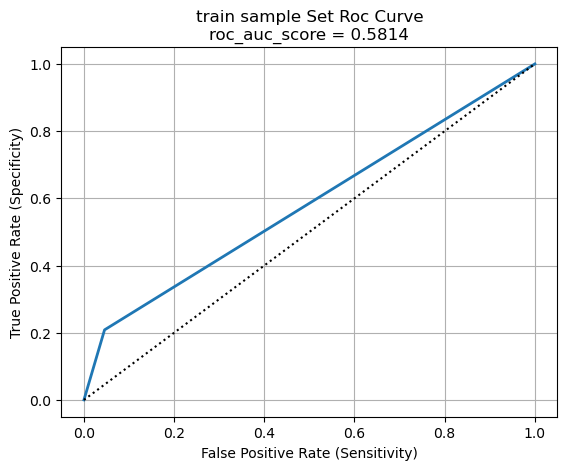


Check Precision-Recall Curve and Average Precision Score


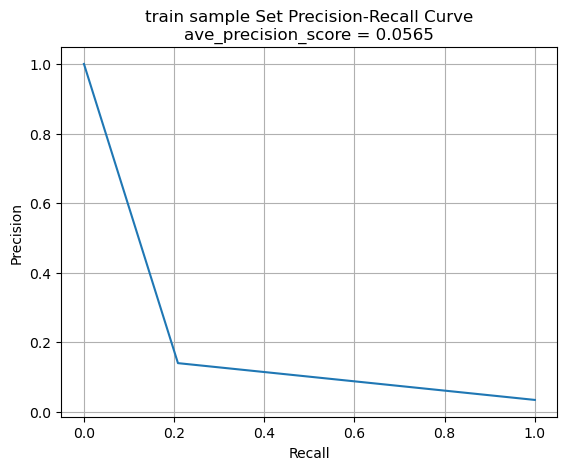

In [13]:
bin_class_utils.eval_class(train_cap_x_df, train_y_df, composite_estimator, "train sample", CVS_SCORING_LIST)

#### 8. Read in and sample validation data set

In [14]:
validation_df = general_utils.read_csv(VALIDATION_FILE_PATH)


Read CSV file ../data/validation_df.csv into DataFrame:
df.head(): 


,uid,task_id,adv_id,creat_type_cd,adv_prim_id,dev_id,inter_type_cd,slot_id,spread_app_id,tags,...,device_price,up_life_duration,up_membership_grade,membership_life_duration,consume_purchase,communication_onlinerate,communication_avgonline_30d,indu_name,pt_d,label
0,1451378,2082,3033,7,154,56,5,11,31,40,...,4,20,-1,-1,7,0^1^2^3^4^5^6^7^8^9^10^11^12^13^14^15^16^17^18...,13,17,5,0
1,1619957,1225,4676,7,178,17,5,17,70,39,...,4,20,-1,-1,2,0^1^2^3^4^5^6^7^8^9^10^11^12^13^14^15^16^17^18...,13,36,6,0
2,1698084,2206,2822,7,177,56,5,14,31,40,...,5,20,1,-1,2,-1,-1,17,3,0
3,1983802,5103,2564,7,151,60,4,12,23,26,...,4,20,-1,-1,8,7^8^9^10^11^12^13^14^15^16^17^18^19^20^21^22^23,10,39,5,0
4,1537560,1098,1732,7,134,55,4,17,65,18,...,4,20,-1,-1,2,3^4^5^6^7^8^9^10^11^12^13^14^15^16^17^18^19^20...,12,14,1,0


df.shape: (167629, 36)


In [15]:
validation_df_sample = data_prepare_utils.sample_data(validation_df, SAMPLE_SIZE, SAMPLE_RANDOM_STATE)
del validation_df


Sample 0.05 fraction from DataFrame:
sample_df.shape: (8381, 36)


In [16]:
validation_cap_x_df, validation_y_df = validation_df_sample.drop(columns=TARGET_ATTR), validation_df_sample[[TARGET_ATTR]]
del validation_df_sample

#### 9. Evaluate model performance on validation set

Evaluate the trained estimator performance on validation sample set
Check accuracy score
validation sample set accuracy score: 0.9204152249134948

Check classification report
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      8092
           1       0.05      0.08      0.06       289

    accuracy                           0.92      8381
   macro avg       0.51      0.51      0.51      8381
weighted avg       0.93      0.92      0.93      8381


Check confusion matrix
validation sample set confusion matrix: 
[[7692  400]
 [ 267   22]]
True Positives =  7692
True Negatives =  22
False Positives(Type I error) =  400
False Negatives(Type II error) =  267

Check cross validation score

accuracy scores: [0.9189028  0.9176611  0.93317422 0.91348449 0.90871122]
np.mean(scores): 0.9183867657753432
np.std(scores, ddof=1): 0.009180283190801027

precision scores: [0.02439024 0.07368421 0.06451613 0.08571429 0.03883495]
np.mean(scores): 0.057427

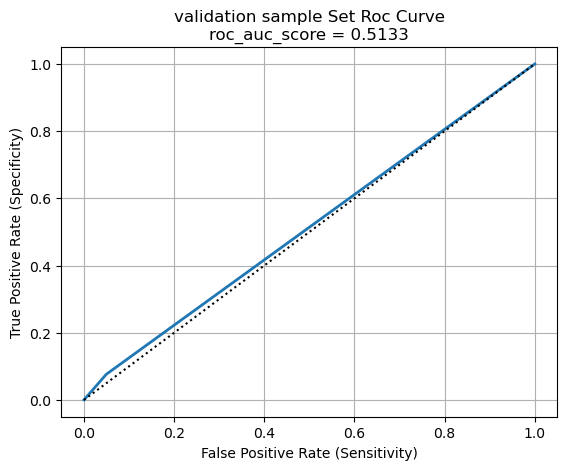


Check Precision-Recall Curve and Average Precision Score


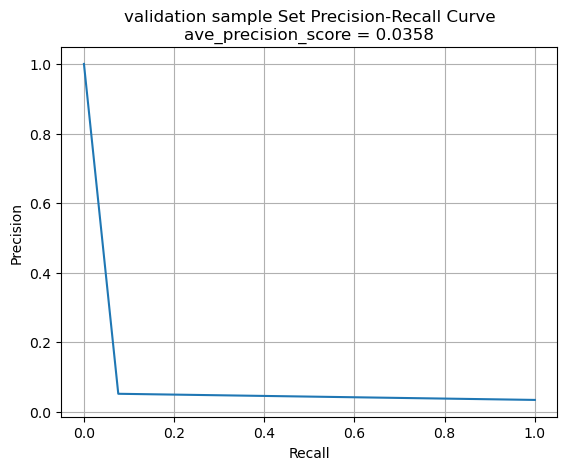

In [17]:
bin_class_utils.eval_class(validation_cap_x_df, validation_y_df, composite_estimator, "validation sample", CVS_SCORING_LIST)

#### 10. Check the most significant attributes

In [18]:
perm_results_df = bin_class_utils.check_out_permutation_importance(
    composite_estimator, 
    train_cap_x_df, 
    train_y_df, 
    PERMUTATION_IMPORTANCE_RANDOM_STATE,
    PERMUTATION_SCORING_LIST
)
perm_results_df


Check out permutation importance:


,metric_name,feature_name,metric_mean,metric_std_dev
0,average_precision,slot_id,0.018511,0.000525
1,average_precision,adv_id,0.015311,0.000977
2,average_precision,age,0.011234,0.000911
3,average_precision,adv_prim_id,0.010413,0.000894
4,average_precision,his_app_size,0.008477,0.000792
5,average_precision,pt_d,0.008429,0.001019
6,average_precision,indu_name,0.007213,0.000656
7,average_precision,career,0.006765,0.000809
8,average_precision,device_name,0.005873,0.001218
9,average_precision,residence,0.004581,0.000974


#### 11. Feature selection and engineering

In [19]:
common_least_important_attrs = bin_class_utils.drop_least_important_attrs(perm_results_df, PERM_DROP_THRESHOLD_PERCENT)
common_least_important_attrs

['emui_dev',
 'app_second_class',
 'gender',
 'device_size',
 'up_life_duration',
 'list_time',
 'up_membership_grade']

#### 12. Fit and evaluate again

In [20]:
attrs_to_drop_exp = list(set(ATTRS_TO_DROP + common_least_important_attrs))
attrs_to_drop_exp

['tags',
 'spread_app_id',
 'emui_dev',
 'uid',
 'app_second_class',
 'gender',
 'app_score',
 'task_id',
 'his_on_shelf_time',
 'dev_id',
 'device_size',
 'up_life_duration',
 'list_time',
 'up_membership_grade']

In [21]:
preprocessor_exp = bin_class_utils.build_preprocessing_pipeline(numerical_attr_list, categorical_attr_list, attrs_to_drop_exp, TARGET_TYPE, TARGET_ENCODING_RANDOM_STATE)

estimator_exp = bin_class_utils.get_default_model(ESTIMATOR_NAME, MODEL_RANDOM_STATE)

composite_estimator_exp = Pipeline(steps=[
    ('preprocessor', preprocessor_exp), 
    ('estimator', estimator_exp)
])

In [22]:
composite_estimator_exp.fit(
    train_cap_x_df,
    train_y_df.values.ravel()
)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('column_dropper',
                                                                   DropColumnsTransformer(attrs_to_drop=['tags',
                                                                                                         'spread_app_id',
                                                                                                         'emui_dev',
                                                                                                         'uid',
                                                                                                         'app_second_class',
                                                                                                         'gender',
                                                                                                         'app_score',
                                                                                                         'task_id',
                                                                                                         'his_on_shelf_time',
                                                                                                         'dev_id',
                                                                                                         'device_size',
                                                                                                         'up_life_duration',
                                                                                                         'list_time',
                                                                                                         'up_membership_grade'])),
                                                                  ('imputer',
                                                                   S...
                                                   'app_second_class', 'age',
                                                   'city', 'city_rank',
                                                   'device_name', 'device_size',
                                                   'career', 'gender',
                                                   'net_type', 'residence',
                                                   'his_app_size',
                                                   'his_on_shelf_time',
                                                   'app_score', 'emui_dev',
                                                   'list_time', 'device_price',
                                                   'up_life_duration',
                                                   'up_membership_grade',
                                                   'membership_life_duration', ...])])),
                ('estimator',
                 DecisionTreeClassifier(class_weight='balanced',
                                        random_state=42))])

Evaluate the trained estimator performance on train sample exp set
Check accuracy score
train sample exp set accuracy score: 0.9347534234314866

Check classification report
              precision    recall  f1-score   support

           0       0.97      0.96      0.97     32363
           1       0.15      0.19      0.17      1156

    accuracy                           0.93     33519
   macro avg       0.56      0.58      0.57     33519
weighted avg       0.94      0.93      0.94     33519


Check confusion matrix
train sample exp set confusion matrix: 
[[31109  1254]
 [  933   223]]
True Positives =  31109
True Negatives =  223
False Positives(Type I error) =  1254
False Negatives(Type II error) =  933

Check cross validation score

accuracy scores: [0.92064439 0.92795346 0.91870525 0.92064439 0.92794271]
np.mean(scores): 0.9231780412503646
np.std(scores, ddof=1): 0.004425814582446386

precision scores: [0.06628242 0.06551724 0.07567568 0.04545455 0.05633803]
np.mean(scores): 0.06

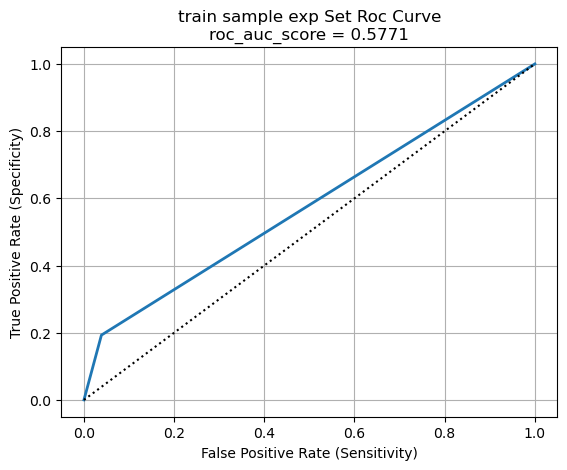


Check Precision-Recall Curve and Average Precision Score


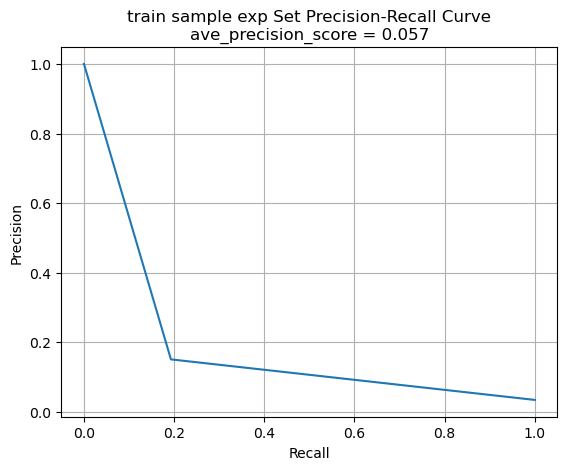

In [23]:
bin_class_utils.eval_class(train_cap_x_df, train_y_df, composite_estimator_exp, "train sample exp", CVS_SCORING_LIST)

Evaluate the trained estimator performance on validation sample exp set
Check accuracy score
validation sample exp set accuracy score: 0.9261424650996302

Check classification report
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      8092
           1       0.07      0.09      0.07       289

    accuracy                           0.93      8381
   macro avg       0.52      0.52      0.52      8381
weighted avg       0.94      0.93      0.93      8381


Check confusion matrix
validation sample exp set confusion matrix: 
[[7737  355]
 [ 264   25]]
True Positives =  7737
True Negatives =  25
False Positives(Type I error) =  355
False Negatives(Type II error) =  264

Check cross validation score

accuracy scores: [0.92009541 0.9278043  0.93675418 0.92422434 0.92303103]
np.mean(scores): 0.9263818501899201
np.std(scores, ddof=1): 0.006422824772841023

precision scores: [0.03658537 0.08974359 0.05555556 0.06329114 0.08235294]
np.mean(score

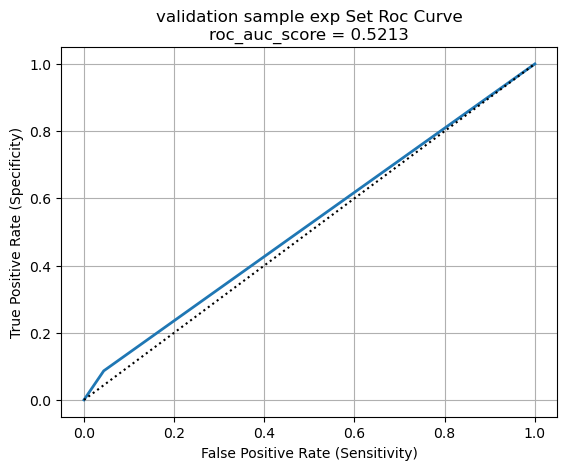


Check Precision-Recall Curve and Average Precision Score


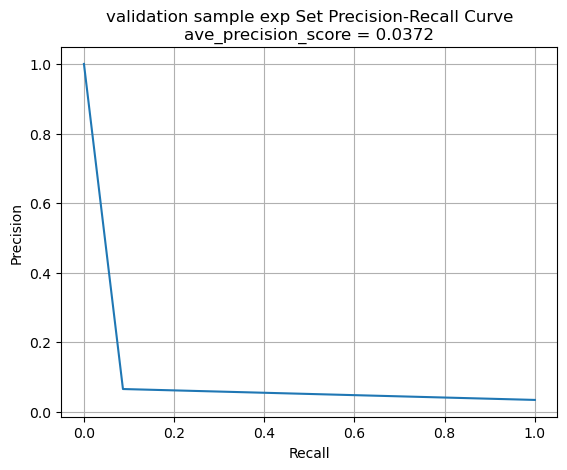

In [24]:
bin_class_utils.eval_class(validation_cap_x_df, validation_y_df, composite_estimator_exp, "validation sample exp", CVS_SCORING_LIST)

- The model performances before and after dropping some common least important features in permutation importance test are similar. 
- `accuracy scores`, `roc_auc_score`, and the mean of `precision scores` in cross validation are very close.
- `precision score` and `recall score` for class 1 show slight improvements.
- `false positives (Type I error)` increases notably after dropping attributes.
- Because minimizing false positives is crucial, we would **not** apply the new drop list in the fine-tuning stage.

In [25]:
attrs_to_drop_for_fine_tuning = ATTRS_TO_DROP

attrs_to_drop_for_fine_tuning

['uid',
 'app_score',
 'his_on_shelf_time',
 'task_id',
 'spread_app_id',
 'tags',
 'dev_id']

In [26]:
end = time.time()
print(f'Script run time: {(end - start)/60} minutes')

Script run time: 5.550776513417562 minutes
